<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Feature Scaling

_Instructor: Aymeric Flaisler_

---

### Learning Objectives
- Explain the benefits of scaling data.
- Identify situations where scaling data is beneficial. 
- Scale data using Python and SKLearn.

### Lesson Guide
- [Introduction to feature scaling](#intro)
- [Why scale data?](#why-scale)
- [Centering](#centering)
- [Standardization](#standardization)
    - [Standardizing with sklearn's `StandardScaler`](#standard-scaler)
- [Normalization](#normalization)
    - [Normalizing with sklearn's `MinMaxScaler`](#minmax)
- [Independent practice scaling the wine dataset](#independent-practice)
- [Additional resources](#resources)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures

<a id='intro'></a>

## Introduction to feature scaling

---

Scaling data is the process of **increasing or decreasing the magnitude** according to a fixed ratio. In other words, you **change the size but not the shape** of the data (the shape of the distribution is unchanged).

Some data scaling methods often change the *location* of the data as well. For example, when **"centering"** we take a distribution and **change it's mean to be zero by subtracting the mean of the distribution from each data point** in the distribution. While this is not technically "scaling", changing the location is often a component of the process and preserves the shape of the data (it just shifts it around).


<a id='why-scale'></a>

## Why should we scale data?

---

**There are a number of good reasons why we scale our data:**
- To handle disparities in units.
- Cut computational expense.
- Improve model performance (Especially Machine Learning).
- We scale for models to prevent the steps on different axes from varying widely.

**It’s rarely a bad idea to scale your data!** 

<a id='centering'></a>

## Centering: changing the location of data

---

We can start with the simplest transformation example: centering. If we have a distribution of values $X$, then to center our data to a new distribution $X_c$:

### $$ X_c = X - \bar{X} $$

### Benefits of centering data

The primary benefit of centering your predictor data in linear modeling is so **the intercept represents the estimate of the target when all predictors are at their mean value.**

If we don't center, the intercept is the estimate of our model when all predictors are at value 0. It often makes the intercept much more interpretable when you center your predictors.

### Centering example: baseball player height and weight

Load in the dataset on the heights, weights, and ages of baseball players.

In [4]:
baseball = pd.read_csv('./datasets/baseball_height_weight.csv')
baseball.columns

Index(['name', 'team', 'position', 'height_in', 'weight_lb', 'age'], dtype='object')

**Plot the distribution of the heights and weights below:**

/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


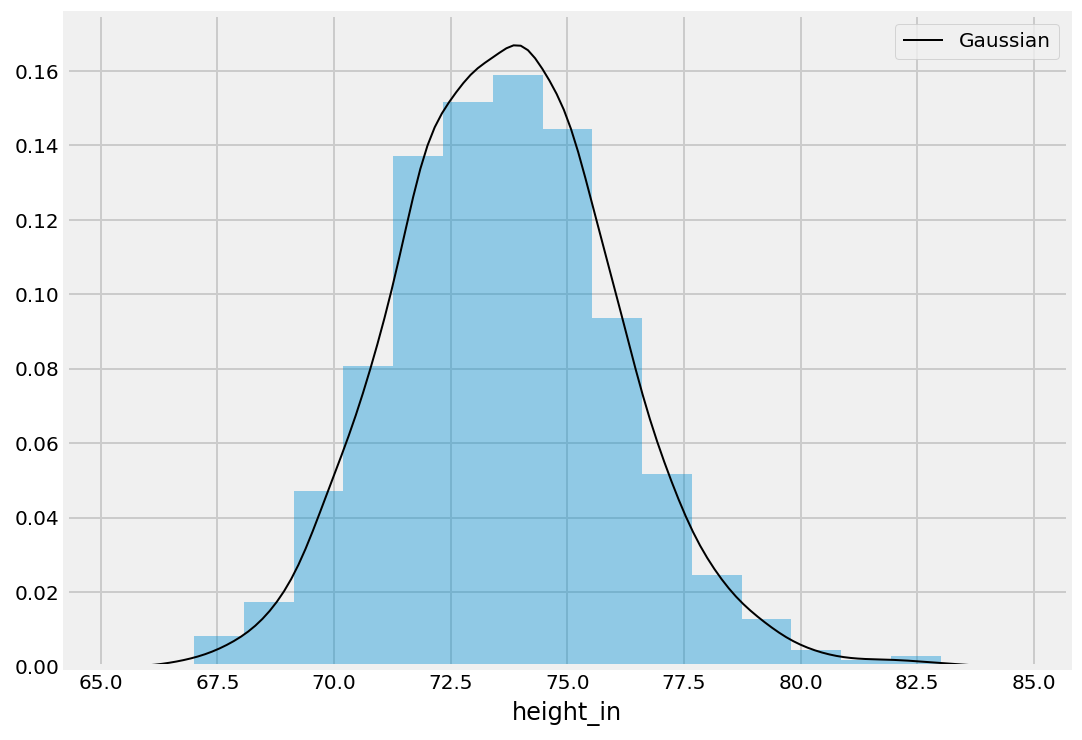

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(baseball.height_in, bins=15, kde_kws={"color": "k", "lw": 1, "label": "Gaussian"})

/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


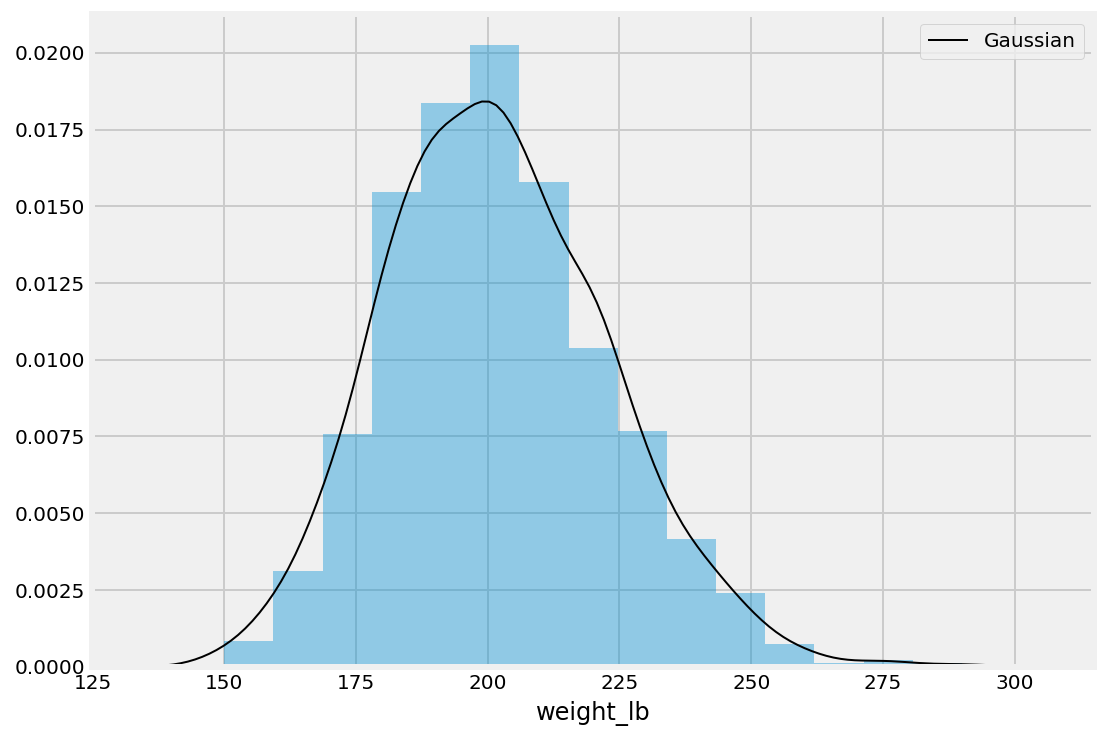

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(baseball.weight_lb, bins=15, kde_kws={"color": "k", "lw": 1, "label": "Gaussian"})

**Construct a linear regression predicting weight from height. Interpret the value of the intercept and the coefficient from this model.**

In [8]:
from sklearn.linear_model import LinearRegression
import patsy

# we can use patsy to quickly create dataframes from columns in a dataframe
# I remove the intercept patsy usually puts in since i'm going to use sklearn.
y, X = patsy.dmatrices('weight_lb ~ height_in -1', data=baseball, return_type='dataframe')
y = y.values.ravel()


linreg = LinearRegression()
linreg.fit(X, y)
print('Intercept:', linreg.intercept_)
print('Height coef:', linreg.coef_)


Intercept: -154.89318451498133
Height coef: [4.83820825]


In [9]:
# Without Patsy

# y = baseball.pop('weight_lb')
# X = baseball[['height_in']]

# linreg = LinearRegression()
# linreg.fit(X, y)
# print('Intercept:', linreg.intercept_)
# print('Height coef:', linreg.coef_)

In [10]:
# The intercept, -154, is the estimated weight of a baseball player when their height is 0 inches.
# The 4.8 coefficient on height is the number of pounds more a player is estimated to weigh for each
# inch of height.

**Center the height variable and re-run the regression with the centered height. Interpret the new intercept and coefficient.**

In [14]:
baseball['height_ctr'] = baseball['height_in'] - baseball['height_in'].mean(axis=0)


In [15]:
# i remove the intercept patsy usually puts in since i'm going to use sklearn.
y, X = patsy.dmatrices('weight_lb ~ height_ctr -1',
                       data=baseball, return_type='dataframe')
y = y.values.ravel()

linreg = LinearRegression()
linreg.fit(X, y)
print('Intercept:', linreg.intercept_)
print('Height centered coef:', linreg.coef_)

Intercept: 201.67151162790697
Height centered coef: [4.83820825]


In [16]:
print(np.mean(baseball.height_in))

73.69767441860465


In [ ]:
# The intercept, 201, is the estimated weight of a baseball player of AVERAGE height (73.69 in).
# The 4.8 coefficient on height is the number of pounds more a player is estimated to weigh for each
# inch of height. This does not change!

<a id='standardization'></a>

## Standardization

---

The **most common method** of scaling is standardization. In standardization we first center the data, then we divide by the standard devation to enforce that the standard deviation of the variable is one:

### $$ X_{std} = \frac{X - \bar{X}}{s_{X}} $$

### Benefits of standardizing data

There are many benefits to standardizing our data, especially when we have more than one predictor:
- Intercepts are interpreted as the estimate when all predictors are at their mean value.
- Coefficients are in units of standard deviations of the original predictors. This allows for direct comparison of the magnitude of impact between different predictors.
- Optimization methods (minimizing loss functions) are faster and more stable.
- In K-Nearest Neighbors methods it is necessary if you want features to contribute equally since these models use the distance between observations calculated from the features.
- In logistic regression, neural networks, and support vector machines unscaled data can result in a disproportionate effect of some data points over others.

> **Note:** In ordinary linear regression centering and scaling your variables does *not* impact the amount of variance you can account for. This is because we are only moving and and adjusting the magnitude of the distribution: the shape of the distribution does not change.

### Standardization example

First, plot the original height variable against the weight variable. Use seaborn's `sns.jointplot`. 

/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


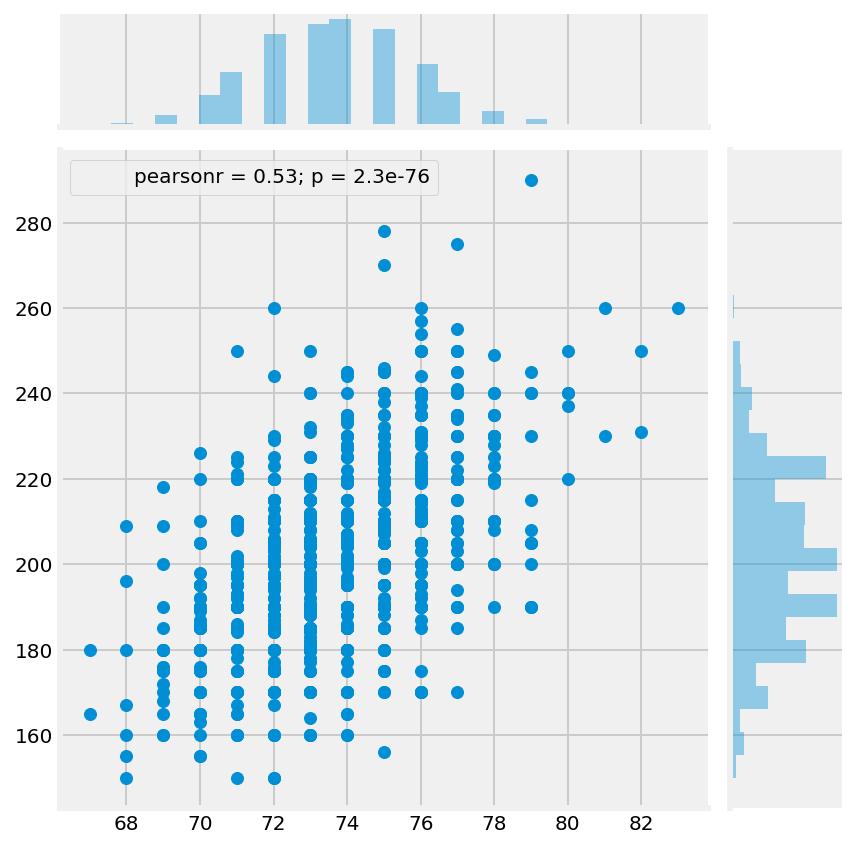

In [18]:
sns.jointplot(baseball.height_in.values, baseball.weight_lb.values)

**Create standardized versions of the height and weight variables.**

In [19]:
baseball['height_std'] = (baseball.height_in - baseball.height_in.mean()) / baseball.height_in.std()
baseball['weight_std'] = (baseball.weight_lb - baseball.weight_lb.mean()) / baseball.weight_lb.std()

**Plot the standardized weight against the height. Notice the distribution shapes and relationship between the variables is unchanged.**

/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


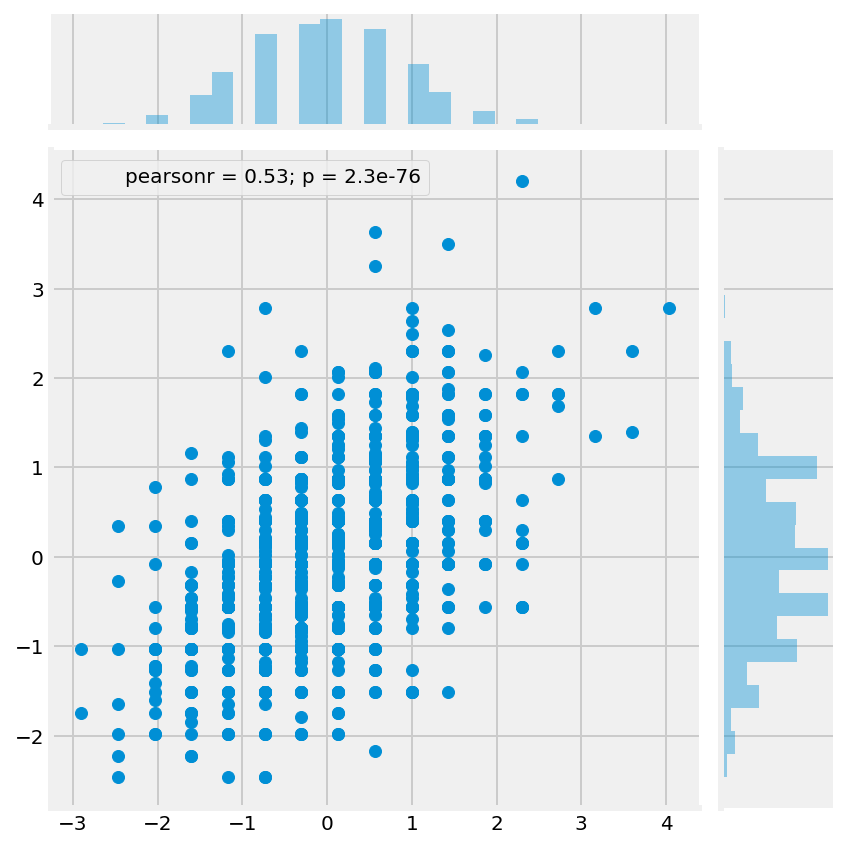

In [20]:
sns.jointplot(baseball.height_std.values, baseball.weight_std.values)

<a id='standard-scaler'></a>
### Using sklearn's `StandardScaler`

Sklearn comes packaged with a class `StandardScaler` that will preform the standardization on a matrix for you. 

Load in the package like so:

```python
from sklearn.preprocessing import StandardScaler
```

Once instantiated, the standard scaler object has three primary methods built in:
- `.fit(X)` will calculate the mean and standard deviations for each column of X
- `.transform(X)` will take X and return a transformed version of X where each column is standardized according to their means and standard deviations (must have run `.fit()` first).
- `.fit_transform(X)` combines the `.fit()` method and the `.transform()` method.

**Use `StandardScaler` to standardize a predictor matrix containing height and weight from the baseball data.**

In [29]:
from sklearn.preprocessing import StandardScaler

# initialize the Scaler
ss = StandardScaler()

# Fit the data using the scaler (scale the data)
Xstd = ss.fit_transform(baseball[['height_in','weight_lb']].values)
print(Xstd.mean(), Xstd.std())

7.659678231909995e-16 0.9999999999999998


**Build a linear regression predicting age from the standardized height and weight data. Interpret the coefficients.**

In [30]:
lr = LinearRegression()
lr.fit(Xstd, baseball.age.values)

print('Intercept:', lr.intercept_)
print('Coefs:', lr.coef_)

Intercept: 28.73415697674419
Coefs: [-0.95285142  1.18796454]


In [25]:
# A 1 standard deviation increase in height estimates -0.95 years age.
# A 1 standard deviation increase in weight estimates 1.18 years age.

<a id='normalization'></a>

## Normalization

---

Normalization most often refers to the process of "normalizing" a variable to be between 0 and 1. Think of this as squishing the variable to be constrained to a specific range.

### $$ X_{norm} = \frac{X - min(X)}{max(X) - min(X)} $$

This type of normalization is typically referred to as "min-max scaling". 

### Benefits of normalization

Typically standardization is preferred to min-max normalization. However, there are some applications where min-max scaling would be preferable:
- Neural networks often require their inputs to be bounded between 0 and 1. 
- In images, for example, where pixels can only take on a specific range of RGB values, data may have to be normalized.

<a id='minmax'></a>
### Normalization with `MinMaxScaler`

Sklearn also has a class for normalization called `MinMaxScaler`:

```python
from sklearn.preprocessing import MinMaxScaler
```

The `MinMaxScaler` has the same `fit()`, `transform()`, and `fit_transform()` methods.

**Normalize the age, height, and weight variables using `MinMaxScaler`**

In [38]:
from sklearn.preprocessing import MinMaxScaler

X = baseball[['age','height_in','weight_lb']]

mms = MinMaxScaler()
#xnorm
Xn = mms.fit_transform(X)

**Look at the min and max ranges for the normalized matrix.**

In [39]:
print(Xn.min(axis=0))
print(Xn.max(axis=0))

[0. 0. 0.]
[1. 1. 1.]


In [40]:
print(Xn.std(axis=0))

[0.15643887 0.14412335 0.14988388]


**Plot the normalize height against the normalized weight.**

/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/jasmine/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


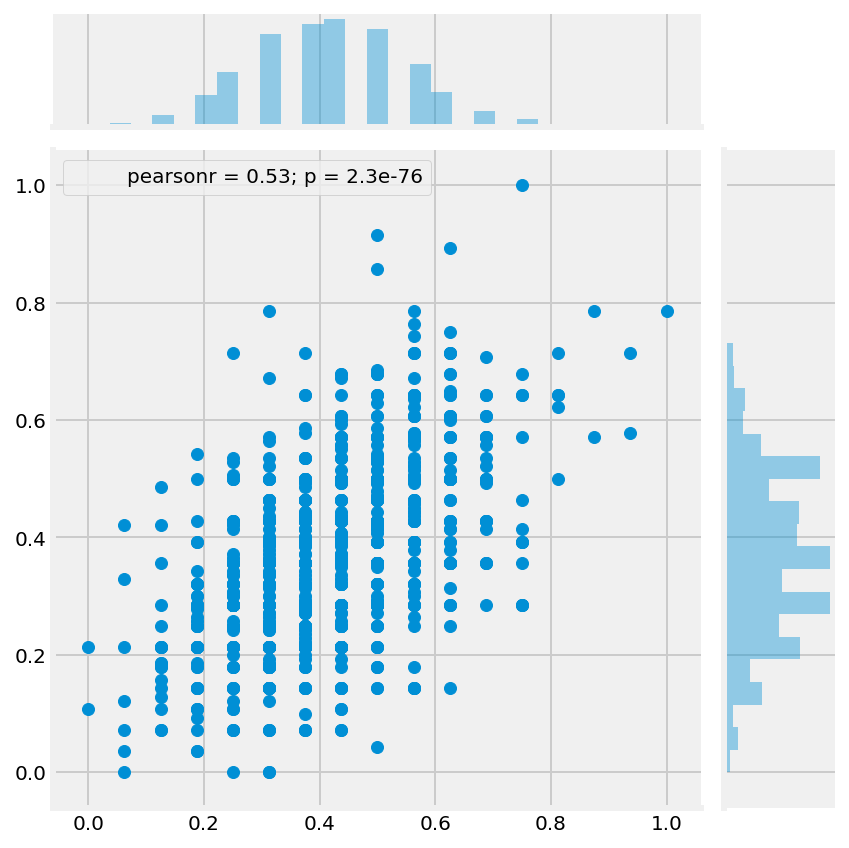

In [41]:
sns.jointplot(Xn[:,1], Xn[:,2])

<a id="imputer"></a>
### Imputer

This processor gives you an sklearn implementation of `.fillna()` in Pandas, but within sklearn. Your choices for imputation are the average value, median value, or most frequent value. If you have a more specific imputation that you want to add, you may want to write a function and use `FunctionTransformer` instead.

```python

from sklearn.preprocessing import Imputer

impute = Imputer(strategy='median')
impute.fit_transform(data)
```

In [42]:
df = pd.read_csv('./datasets/preproc.csv')

In [43]:
impute = Imputer(strategy='mean')
impute.fit_transform(df)

array([[  1.,  10.],
       [  2., 105.],
       [  3., 105.],
       [  4., 105.],
       [  5., 105.],
       [  6., 105.],
       [  7., 105.],
       [  8., 105.],
       [  9., 105.],
       [ 10., 200.]])

<a id="polynomialfeatures"></a>
### PolynomialFeatures

This preprocessor creates polynomial terms and, optionally, interaction terms from your input. By default it will also put a _bias_ term as well. This example shows a case without the bias term.

```python
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

data = np.array([1, 2, 3, 4, 5])
pf = PolynomialFeatures(3, include_bias=False)
pf.fit_transform(data.reshape(-1, 1))

array([[   1.,    1.,    1.],
       [   2.,    4.,    8.],
       [   3.,    9.,   27.],
       [   4.,   16.,   64.],
       [   5.,   25.,  125.]])
```

In [44]:
df

,col1,col2
0,1,10.0
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN
5,6,NaN
6,7,NaN
7,8,NaN
8,9,NaN
9,10,200.0


In [33]:
pf = PolynomialFeatures(degree=3, include_bias=True)

In [34]:
#first cloumns is a bizs just an constent 
pf.fit_transform(df[['col1']])

array([[   1.,    1.,    1.,    1.],
       [   1.,    2.,    4.,    8.],
       [   1.,    3.,    9.,   27.],
       [   1.,    4.,   16.,   64.],
       [   1.,    5.,   25.,  125.],
       [   1.,    6.,   36.,  216.],
       [   1.,    7.,   49.,  343.],
       [   1.,    8.,   64.,  512.],
       [   1.,    9.,   81.,  729.],
       [   1.,   10.,  100., 1000.]])

Those are common preprocessors but you have many more available 
(http://scikit-learn.org/stable/modules/preprocessing.html): 
```
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import KernelCenterer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import binarize
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
```


### A Dummy’s Guide to Creating Dummy Variables

Sometimes you need to quantify qualitative variables. Luckily, there’s a nice, neat function that can help us do that!



Pandas has a function which can turn a categorical variable into a series of zeros and ones, which makes them a lot easier to quantify and compare.


In [45]:
df_sub = baseball[:30]
df_sub.position.value_counts()

Starting_Pitcher     7
Outfielder           7
Relief_Pitcher       6
Catcher              3
Third_Baseman        2
First_Baseman        2
Second_Baseman       1
Designated_Hitter    1
Shortstop            1
Name: position, dtype: int64

In [36]:
df_sub.head()

,name,team,position,height_in,weight_lb,age,height_ctr,height_std,weight_std
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99,0.302326,0.131042,-1.032276
1,Paul_Bako,BAL,Catcher,74,215.0,34.69,0.302326,0.131042,0.634874
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78,-1.697674,-0.735850,0.396710
3,Kevin_Millar,BAL,First_Baseman,72,210.0,35.43,-1.697674,-0.735850,0.396710
4,Chris_Gomez,BAL,First_Baseman,73,188.0,35.71,-0.697674,-0.302404,-0.651213


In [48]:
pd.get_dummies(df_sub,columns=['position']).head()

,name,team,height_in,weight_lb,age,height_ctr,height_std,weight_std,position_Catcher,position_Designated_Hitter,position_First_Baseman,position_Outfielder,position_Relief_Pitcher,position_Second_Baseman,position_Shortstop,position_Starting_Pitcher,position_Third_Baseman
0,Adam_Donachie,BAL,74,180.0,22.99,0.302326,0.131042,-1.032276,1,0,0,0,0,0,0,0,0
1,Paul_Bako,BAL,74,215.0,34.69,0.302326,0.131042,0.634874,1,0,0,0,0,0,0,0,0
2,Ramon_Hernandez,BAL,72,210.0,30.78,-1.697674,-0.735850,0.396710,1,0,0,0,0,0,0,0,0
3,Kevin_Millar,BAL,72,210.0,35.43,-1.697674,-0.735850,0.396710,0,0,1,0,0,0,0,0,0
4,Chris_Gomez,BAL,73,188.0,35.71,-0.697674,-0.302404,-0.651213,0,0,1,0,0,0,0,0,0


Et voila! :)

<a id='independent-practice'></a>

## Independent practice: scaling the wine dataset

---

Below you'll load in the wine quality dataset. This dataset contains a variety of features for different types/brands of wine. 

**You should:**
1. Load and examine the data.
2. Create a target variable for wine quality.
3. Create a predictor matrix with variables of your choice.
4. Create a standardized and normalized version of your predictor matrix.
5. Using cross-validation, calculate the average $R^2$ score for wine quality using the original predictors, the standardized predictors, and the normalized predictors.

**1. Load and examine the data.**

In [49]:
# A:
data = 'datasets/winequality_merged.csv'
data_wineq = pd.read_csv(data)
data_wineq.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'red_wine'],
      dtype='object')

In [50]:
data_wineq.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


**2. Create a target variable for wine quality.**

In [51]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(11, 7))

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

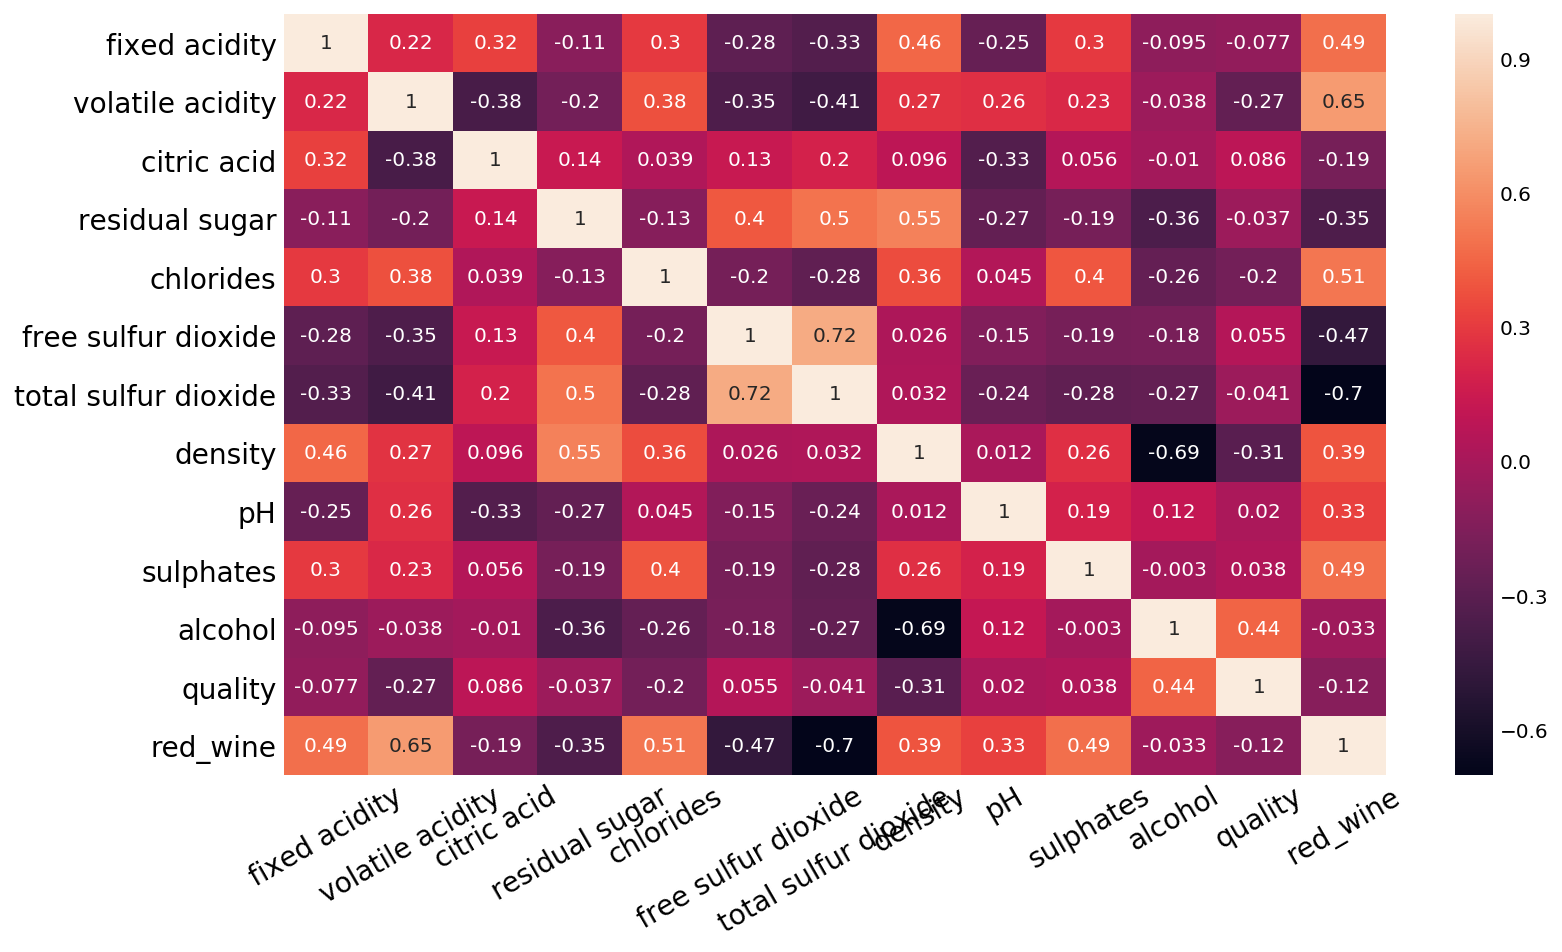

In [57]:
# A:
y = data_wineq['quality']
correlation_heat_map(data_wineq)

**3. Create a predictor matrix with variables of your choice.**

In [66]:
# A:
predictor_matrix = data_wineq[['volatile acidity','chlorides','density']]


In [67]:
predictor_matrix.head()

,volatile acidity,chlorides,density
0,0.70,0.076,0.9978
1,0.88,0.098,0.9968
2,0.76,0.092,0.9970
3,0.28,0.075,0.9980
4,0.70,0.076,0.9978


**4. Create a standardized and normalized version of your predictor matrix.**

In [68]:
# A:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
#xnorm
Xn = mms.fit_transform(predictor_matrix)
Xn

array([[0.41333333, 0.11129568, 0.20609215],
       [0.53333333, 0.14784053, 0.18681319],
       [0.45333333, 0.13787375, 0.19066898],
       ...,
       [0.10666667, 0.05315615, 0.10468479],
       [0.14      , 0.02159468, 0.03046077],
       [0.08666667, 0.01827243, 0.04434162]])

In [69]:
from sklearn.preprocessing import StandardScaler

# initialize the Scaler
ss = StandardScaler()

# Fit the data using the scaler (scale the data)
Xstd = ss.fit_transform(predictor_matrix.values)
print(Xstd.mean(), Xstd.std())

-1.1140621827935284e-15 1.0


**5. Using cross-validation, calculate the average $R^2$ score for wine quality using the original predictors, the standardized predictors, and the normalized predictors.**

In [71]:
# A: for the StandardScaler
lr = LinearRegression()
lr.fit(Xstd, data_wineq.quality.values)

print('Intercept:', lr.intercept_)
print('Coefs:', lr.coef_)


#  for the StandardScaler
lr = LinearRegression()
lr.fit(Xn, data_wineq.quality.values)

print('Intercept:', lr.intercept_)
print('Coefs:', lr.coef_)

Intercept: 5.818377712790518
Coefs: [-0.16058121 -0.03870179 -0.20947265]
Intercept: 6.653635728437607
Coefs: [-1.46316514 -0.66508359 -3.62366378]


<a id='resources'></a>

## Additional resources

---

[About feature scaling and normalization.](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)